In [1]:
import sys
import numpy as np
from scipy.constants import c as C
import FTIR_functions as FTIR
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({"font.size": 20, "xtick.direction": "in", "ytick.direction": "in"})
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
File = open("data\\plotDataqq.txt", 'rt')
epac_data = np.loadtxt(File, delimiter = " ")
File.close()

ideal_z, ideal_bunch = epac_data.T # Z displacement in um, bunch profile normalised to its peak, the electrons are traveling to the right such that the rightmost electrons will reach the detector first.

ideal_time = ideal_z *1e-6 /C # in s
ideal_bunch = ideal_bunch[::-1] # electrons are traveling to the right so the rightmost electrons arrive first.
ideal_sampling_period = np.median(np.diff(ideal_time)) # should be regularly spaced anyway
ideal_N = len(ideal_time)

In [3]:
padding = 10000 # number of samples to zero padd at the end of the bunch

ideal_time = np.append(ideal_time, ideal_time[-1] +ideal_sampling_period*np.arange(padding))
ideal_bunch = np.append(ideal_bunch, np.zeros(padding))
padded_N = len(ideal_bunch) # = ideal_N +padding

#ideal_time = np.append(ideal_sampling_period*np.arange(padded_N-2) -ideal_time[-1], ideal_time)
#ideal_bunch = np.append(np.zeros(padded_N -2), ideal_bunch)
#padded_N = len(ideal_bunch)

In [4]:
### Replace the EPAC bunch with a gaussian distrobution. Useful for testing.

#ideal_bunch = FTIR.gaussian(ideal_time, 150e-15, FWHMs["delayed"])

In [5]:
ideal_CFF = np.fft.rfft(ideal_bunch, norm= "forward")
ideal_CFF /= np.max(ideal_CFF) #normalise to peak
ideal_freqs = np.fft.rfftfreq(padded_N, ideal_sampling_period)

ideal_FF = np.abs(ideal_CFF)**2
ideal_FF /= np.max(ideal_FF) #normalise to peak

c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\FTIR_functions.py:25: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa.


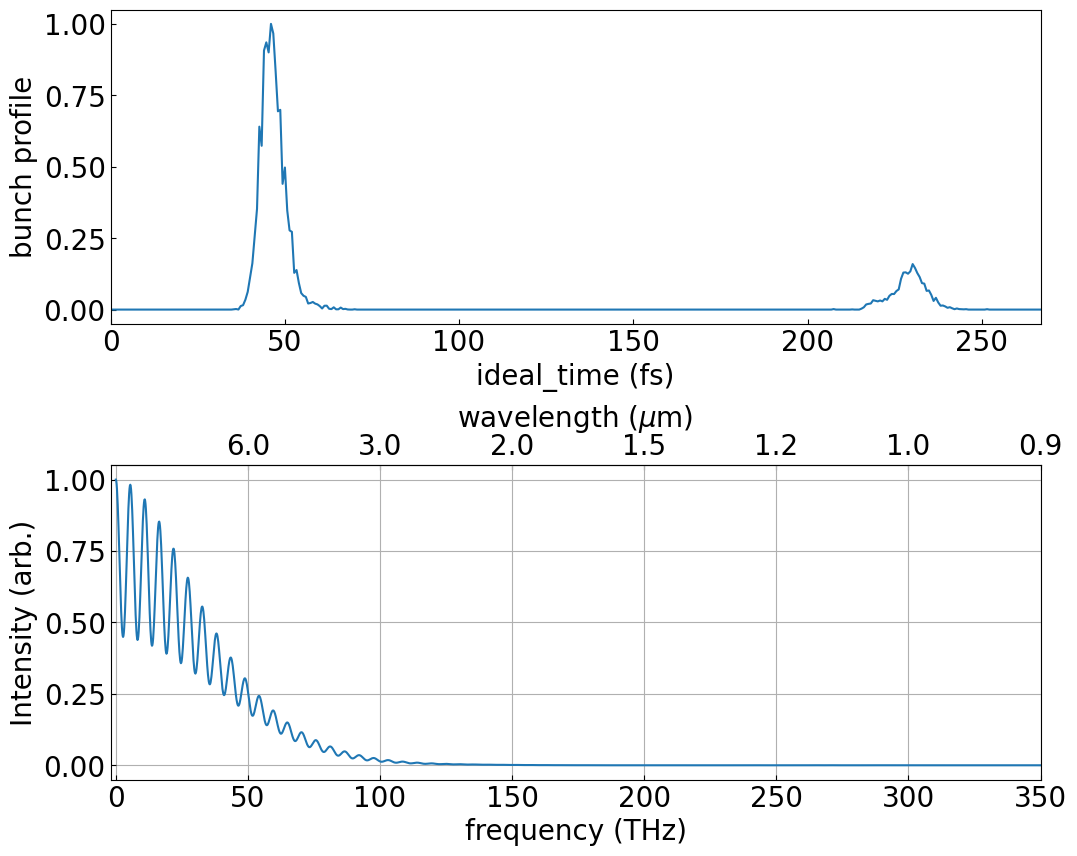

In [6]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.45})

axs[0].plot(ideal_time *1e15, ideal_bunch)
axs[0].set(xlabel= "ideal_time (fs)", ylabel= "bunch profile", xlim= (0, ideal_N*ideal_sampling_period*1e15))

axs[1].plot(ideal_freqs *1e-12, ideal_FF)
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 350))
axs[1].grid(True)

secax = axs[1].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

plt.show()

In [8]:
kk_phase = FTIR.kramers_kronig(ideal_freqs, np.sqrt(ideal_FF))
kk_CFF = np.sqrt(ideal_FF) *np.exp(1j*kk_phase)
gs_CFF = FTIR.gerchberg_saxon(np.sqrt(ideal_FF))

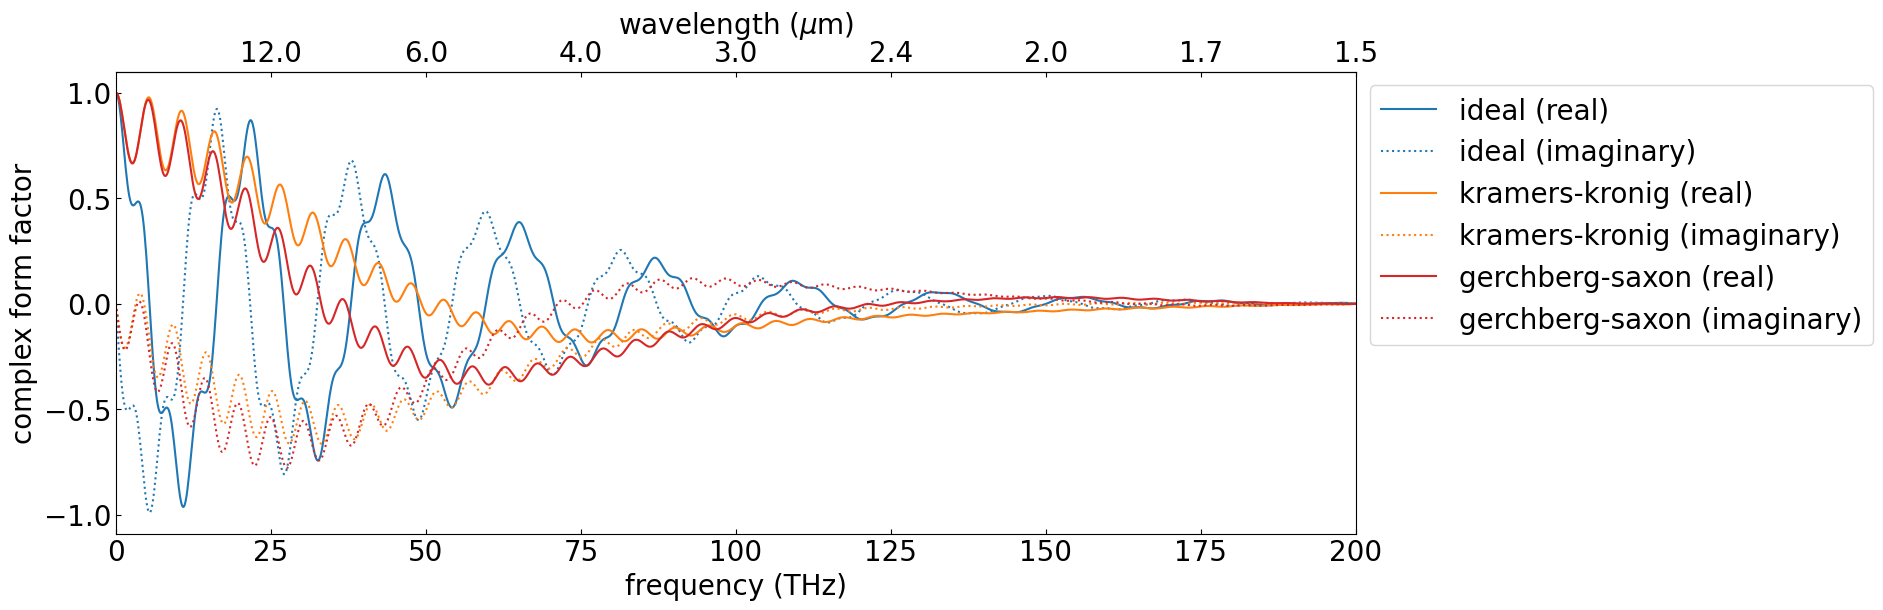

In [9]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_CFF.real, color= "tab:blue", label= "ideal (real)")
axs.plot(ideal_freqs *1e-12, ideal_CFF.imag, color= "tab:blue", linestyle= ":", label= "ideal (imaginary)")

axs.plot(ideal_freqs *1e-12, kk_CFF.real, color= "tab:orange", label= "kramers-kronig (real)")
axs.plot(ideal_freqs *1e-12, kk_CFF.imag, color= "tab:orange", linestyle= ":", label= "kramers-kronig (imaginary)")

axs.plot(ideal_freqs *1e-12, gs_CFF.real, color= "tab:red", label= "gerchberg-saxon (real)")
axs.plot(ideal_freqs *1e-12, gs_CFF.imag, color= "tab:red", linestyle= ":", label= "gerchberg-saxon (imaginary)")

axs.set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 200))

secax2 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [10]:
ideal_phase = np.unwrap(np.angle(ideal_CFF))
gs_phase = np.unwrap(np.angle(gs_CFF))

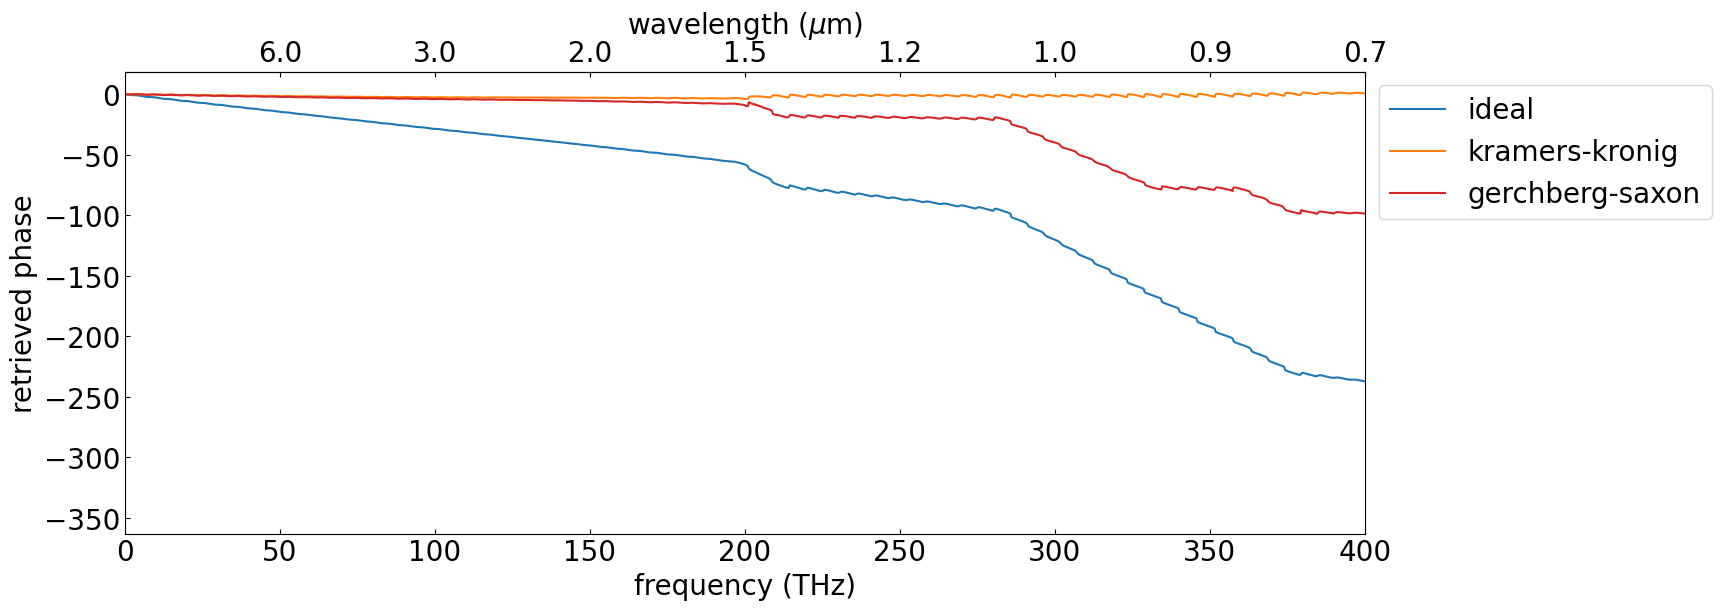

In [11]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_phase, color= "tab:blue", label= "ideal")
axs.plot(ideal_freqs *1e-12, kk_phase, color= "tab:orange", label= "kramers-kronig")
axs.plot(ideal_freqs *1e-12, gs_phase, color= "tab:red", label= "gerchberg-saxon")

axs.set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 400))

secax1 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [12]:
kk_bunch = np.fft.irfft(kk_CFF, norm= "forward", n= padded_N)
kk_bunch /= kk_bunch.max()
gs_bunch = np.fft.irfft(gs_CFF, norm= "forward", n= padded_N)
gs_bunch /= gs_bunch.max()

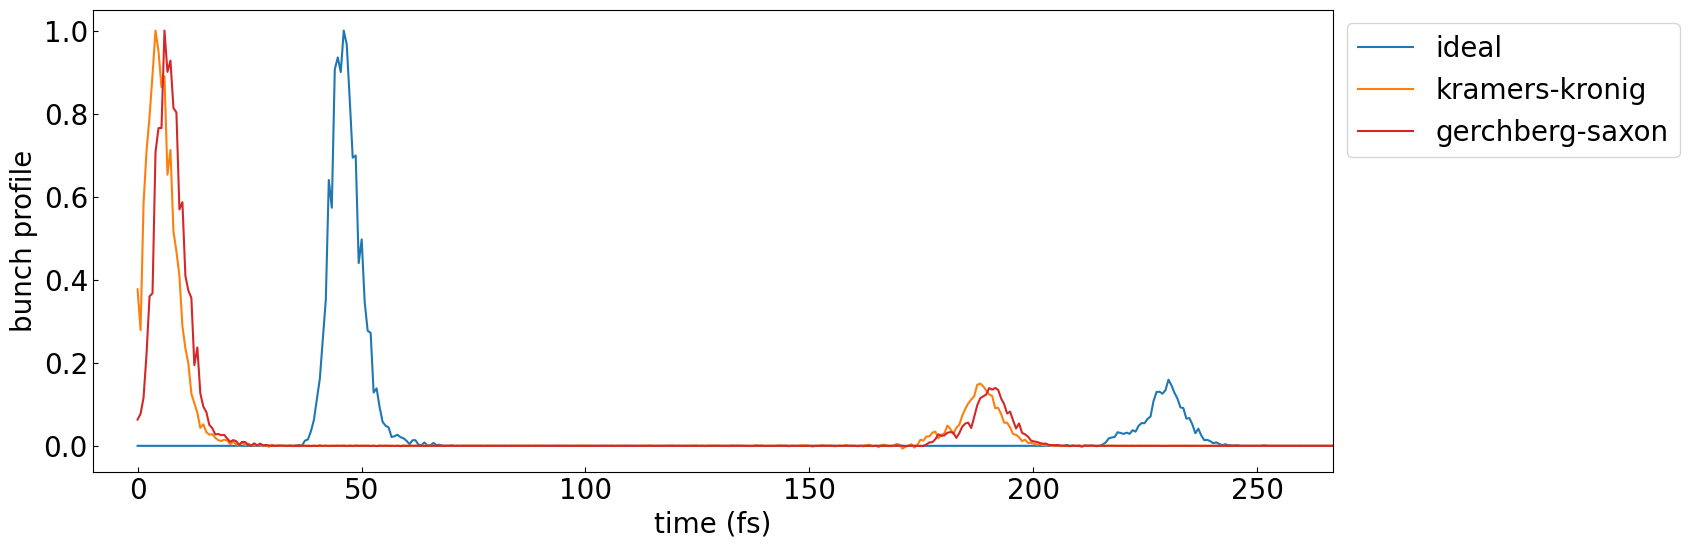

In [13]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "ideal")
axs.plot(ideal_time *1e15, kk_bunch, color= "tab:orange", label= "kramers-kronig")
axs.plot(ideal_time *1e15, gs_bunch, color= "tab:red", label= "gerchberg-saxon")

axs.set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, ideal_N*ideal_sampling_period*1e15))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [14]:
ideal_peak = ideal_time[np.argmax(ideal_bunch)]

kk_peak = ideal_time[np.argmax(kk_bunch)]
kk_fudged = kk_phase -2*np.pi*ideal_freqs* (ideal_peak -kk_peak) # Equivalently, change the phase

gs_peak = ideal_time[np.argmax(gs_bunch)]
gs_fudged = gs_phase -2*np.pi*ideal_freqs* (ideal_peak -gs_peak) # Equivalently, change the phase

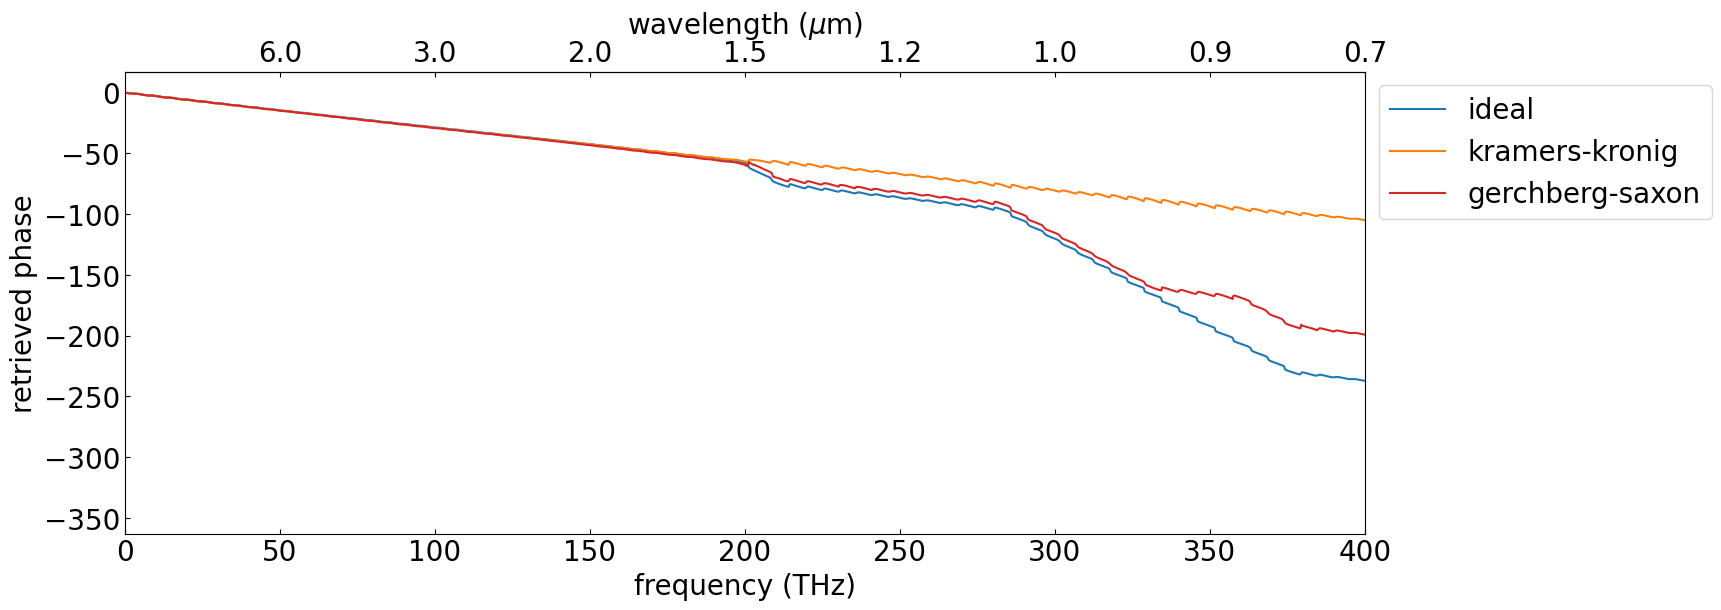

In [15]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_phase, color= "tab:blue", label= "ideal")
axs.plot(ideal_freqs *1e-12, kk_fudged, color= "tab:orange", label= "kramers-kronig")
axs.plot(ideal_freqs *1e-12, gs_fudged, color= "tab:red", label= "gerchberg-saxon")

axs.set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 400))

secax1 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [16]:
kk_bunch = np.fft.irfft(np.abs(kk_CFF) *np.exp(1j*kk_fudged), norm= "forward", n= padded_N)
kk_bunch /= kk_bunch.max()
gs_bunch = np.fft.irfft(np.abs(gs_CFF) *np.exp(1j*gs_fudged), norm= "forward", n= padded_N)
gs_bunch /= gs_bunch.max()

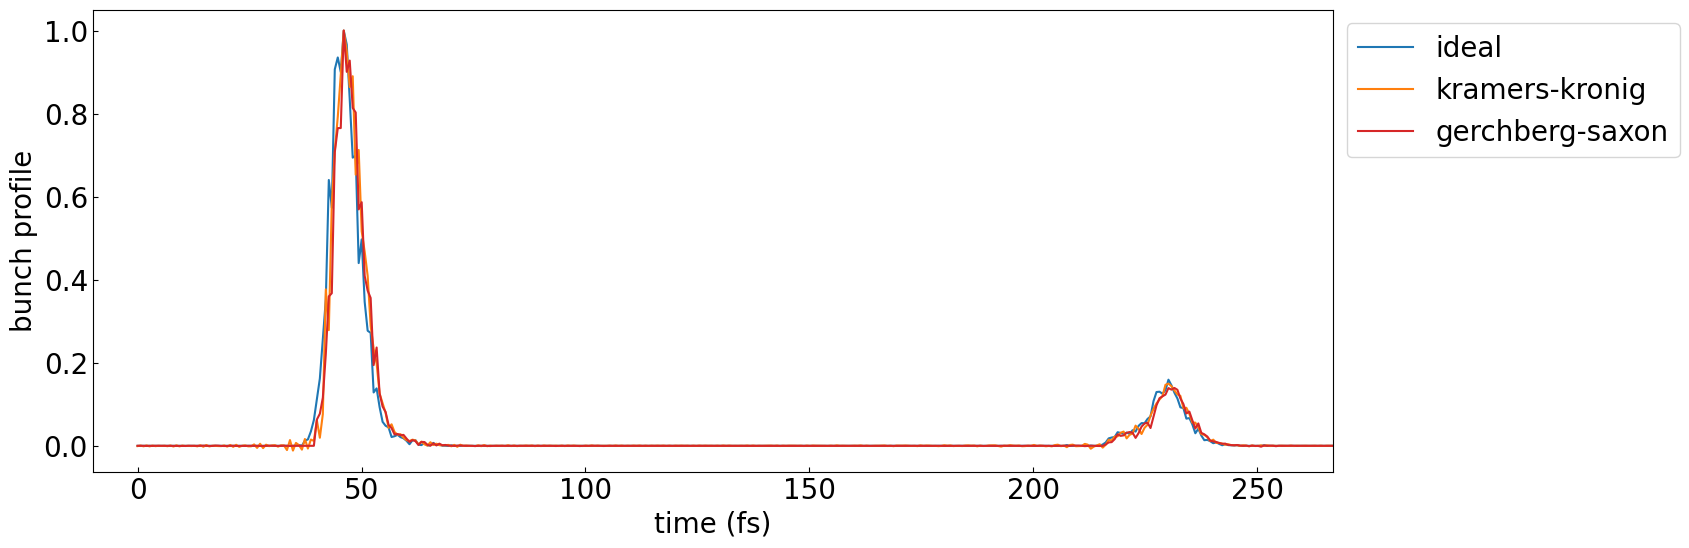

In [17]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "ideal")
axs.plot(ideal_time *1e15, kk_bunch, color= "tab:orange", label= "kramers-kronig")
axs.plot(ideal_time *1e15, gs_bunch, color= "tab:red", label= "gerchberg-saxon")

axs.set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, ideal_N*ideal_sampling_period*1e15))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()